In [1]:
# TensorFlow and tf.keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import h5py

2.0.0-alpha0


Import data:

In [2]:
data = np.load('classify_circles_data.npz')
circleData = data["circles"]
labels = np.column_stack((data['radiilab'],data['distlab']))
n_data = len(labels)
grid = 32
print(labels)

[[23. 18.  5.]
 [29. 25.  7.]
 [21. 23.  1.]
 ...
 [27. 18.  2.]
 [22. 21.  1.]
 [27. 30. 11.]]


Print a plot of data to see what it looks like!

radius1, radius2, distance between ceneters:
[24. 31. 14.]


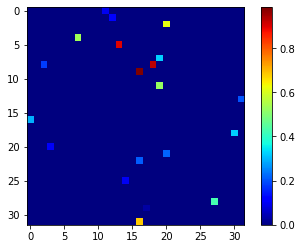

In [3]:
display = circleData[60].reshape(grid,grid)
plt.grid(False)
plt.imshow(display, cmap = 'jet')
print("radius1, radius2, distance between ceneters:")
print(labels[60])
plt.colorbar()

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

In [4]:
data = circleData.reshape(n_data, grid, grid, 1)
split = int(0.8*len(circleData))
train_data = data[:split]
train_labels = labels[:split]
print (train_data.shape)
test_data = data[split:]
print(test_data.shape)
test_labels = labels[split:]

(8000, 32, 32, 1)
(2000, 32, 32, 1)


Build DNN:

In [5]:
def build_model():
    model = keras.Sequential([
        Conv2D(32, (11, 11), activation='relu',
               input_shape=(grid, grid, 1)),
        Conv2D(32, (3, 3), activation='relu'
              ),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Conv2D(32, (3, 3), activation='relu'
              ),
        Conv2D(32, (3, 3), activation='relu'
              ),
        MaxPool2D((2, 2)),
#         Dropout(0.2),
        Flatten(),
        Dense(64, activation=tf.nn.relu),
        Dense(64, activation=tf.nn.relu),
#         Dropout(0.2),
        Dense(3, activation=tf.nn.relu)
      ])

    model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error', 'mean_absolute_error', 'accuracy'])
    return model

Initialize model:

In [6]:
circleCNN = build_model()

Test model's prediction $before$ training:

In [7]:
example_batch = train_data[:10]
example_labels = train_labels[:10]
example_result = circleCNN.predict(example_batch)
results = circleCNN.evaluate(example_batch, example_labels)
example_result

10/10 [==============================] - 0s 7ms/sample - loss: 338.8626 - mean_squared_error: 338.8626 - mean_absolute_error: 16.6970 - accuracy: 0.5000


array([[0.00824911, 0.        , 0.00321137],
       [0.00759777, 0.        , 0.00219931],
       [0.00880869, 0.        , 0.00255115],
       [0.00949403, 0.00131852, 0.00328486],
       [0.00183412, 0.        , 0.00037542],
       [0.00512521, 0.        , 0.00272616],
       [0.00420143, 0.        , 0.00208624],
       [0.00824994, 0.        , 0.00274527],
       [0.00397504, 0.00139541, 0.00280671],
       [0.00463188, 0.        , 0.00212906]], dtype=float32)

Now train! (warning: if building CNN, computer tends to get loud)

In [8]:
 class PrintDot(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs):
     if epoch % 100 == 0: 
         print('')
     print('.', end='')
    
checkpoint_path = "training/CNN_sparse_largerkernel.h5"


# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
 EPOCHS = 1000
 early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
 history = circleCNN.fit(
   train_data, train_labels,
   epochs=EPOCHS, validation_split = 0.2, verbose = 0,
   callbacks=[early_stop, model_checkpoint])


Epoch 00001: val_loss improved from inf to 21.53788, saving model to training/CNN_sparse_largerkernel.h5

Epoch 00002: val_loss improved from 21.53788 to 21.14053, saving model to training/CNN_sparse_largerkernel.h5

Epoch 00003: val_loss improved from 21.14053 to 20.92964, saving model to training/CNN_sparse_largerkernel.h5

Epoch 00004: val_loss improved from 20.92964 to 20.25698, saving model to training/CNN_sparse_largerkernel.h5

Epoch 00005: val_loss did not improve from 20.25698

Epoch 00006: val_loss did not improve from 20.25698

Epoch 00007: val_loss improved from 20.25698 to 20.00176, saving model to training/CNN_sparse_largerkernel.h5

Epoch 00008: val_loss improved from 20.00176 to 17.84587, saving model to training/CNN_sparse_largerkernel.h5

Epoch 00009: val_loss improved from 17.84587 to 16.96819, saving model to training/CNN_sparse_largerkernel.h5

Epoch 00010: val_loss improved from 16.96819 to 15.35822, saving model to training/CNN_sparse_largerkernel.h5

Epoch 0001

Now make a plot that shows the pregression of accuracy through each training epoch.

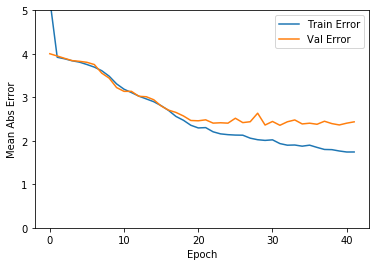

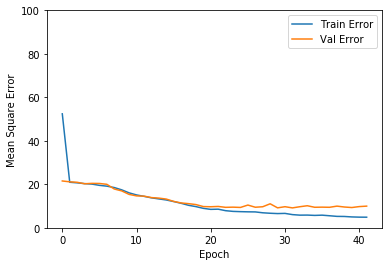

In [9]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,100])
  plt.legend()
  plt.show()

plot_history(history)

Load best weights.

In [10]:
!ls training
best_model = tf.keras.models.load_model('training/CNN_sparse_largerkernel.h5')
best_model.summary()
results = best_model.evaluate(test_data, test_labels)

CNN_L2norm_dropout_padding.h5    CNN_l2reg_moreDropout.h5
CNN_L2reg.h5                     CNN_moreL2reg.h5
CNN_L2reg0.h5                    CNN_moreL2reg0.h5
CNN_L2reg_dropout_lessPadding.h5 CNN_moreL2reg_dropout.h5
CNN_L2reg_dropout_padding.h5     CNN_sparse.h5
CNN_L2reg_reluOutput.h5          CNN_sparse_largerkernel.h5
CNN_L2reg_reluOutput_dropout.h5  CNNbest.h5
CNN_basic.h5                     cpbest.h5
CNN_dropout.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        3904      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)         

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

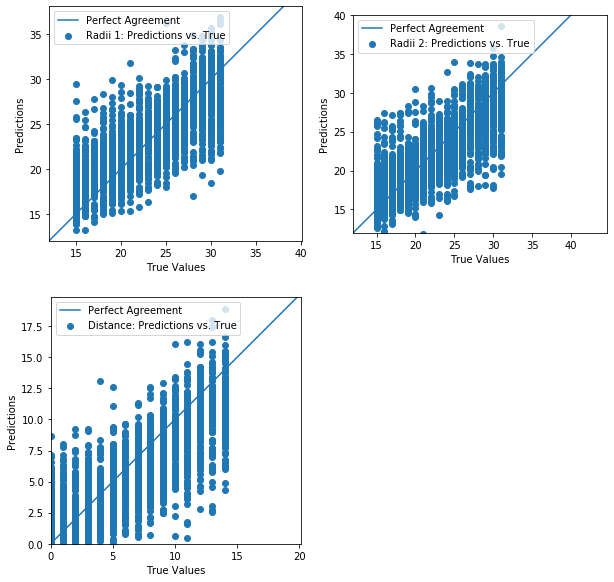

In [11]:
test_predictions = circleCNN.predict(test_data)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.scatter(test_labels[:,0], test_predictions[:,0], label='Radii 1: Predictions vs. True')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([12,plt.xlim()[1]])
plt.ylim([12,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], label="Perfect Agreement")
plt.legend(loc='upper left')
plt.subplot(222)
plt.scatter(test_labels[:,1], test_predictions[:,1], label='Radii 2: Predictions vs. True')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([12,plt.xlim()[1]])
plt.ylim([12,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], label="Perfect Agreement")
plt.legend(loc='upper left')
plt.subplot(223)
plt.scatter(test_labels[:,2], test_predictions[:,2], label='Distance: Predictions vs. True')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], label="Perfect Agreement")
plt.legend(loc='upper left')